In [350]:
from datetime import datetime, timedelta
import calendar
import requests
from textblob import TextBlob

from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

In [351]:
yesterday = datetime.now() - timedelta(days=1)
date_for_news_u = yesterday.strftime("%Y-%m-%d")
date_for_news_l = (yesterday - timedelta(days=9)).strftime("%Y-%m-%d")
# print(date_for_news_u, date_for_news_l)


date_for_coin = datetime.utcnow()
date_c_u = date_for_coin.date()
date_c_l = date_for_coin.date()

date_for_coin_u = date_c_u.strftime("%d-%m-%Y %H:%M:%S")
date_for_coin_l = date_c_l.strftime("%d-%m-%Y %H:%M:%S")

date_for_coin_u = datetime.strptime(date_for_coin_u, "%d-%m-%Y %H:%M:%S")
date_for_coin_l = datetime.strptime(date_for_coin_l, "%d-%m-%Y %H:%M:%S") - timedelta(days=10)

# print(date_for_coin_u, date_for_coin_l)
date_for_coin_u = calendar.timegm(date_for_coin_u.utctimetuple())-1
date_for_coin_l = calendar.timegm(date_for_coin_l.utctimetuple())
# date_for_coin_u, date_for_coin_l

news data

In [352]:
date_for_news_l, date_for_news_u, date_for_coin_l, date_for_coin_u

('2023-10-08', '2023-10-17', 1696723200, 1697587199)

In [354]:
url = ('https://newsapi.org/v2/everything?'
       'q=bitcoin+investment&'
       f'from={date_for_news_l}&'
       f'to={date_for_news_u}&'
       'sortBy=popularity&'
       'apiKey=abb843aff2e648ccb76d00bd7d7ccb67')

response = requests.get(url)

news_data = response.json()

In [355]:
len(news_data)

3

In [356]:
data = news_data['articles']
texts = []
dates = []

for article in data:
    overall_text = article['title'] + article['description'] + article['content']
    date = article['publishedAt'][:10]
    date = datetime.strptime(date, "%Y-%m-%d")

    texts.append(overall_text)
    dates.append(date)

df_news = pd.DataFrame({"text": texts, "date": dates})

In [357]:
df_news = df_news.sort_values(by=['date']).reset_index(drop=True)

In [358]:
# df_news[df_news["text"] == "[Removed][Removed][Removed]"]
df_news = df_news[~(df_news["text"] == "[Removed][Removed][Removed]")]

In [359]:
df_news['sentiment'] = df_news['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# df_news.head()

In [360]:
df_news['sentiment'] = df_news['sentiment'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
# df_news

In [361]:
df_news_new = pd.DataFrame(df_news.groupby('date')['sentiment'].mean()).reset_index()

In [362]:
# df_news_new

In [363]:
date_for_coin_l, date_for_coin_u

(1696723200, 1697587199)

In [364]:
url = f'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from={date_for_coin_l}&to={date_for_coin_u}'

response = requests.get(url)

coin_data = response.json()

In [365]:
coin_data['prices'].pop(125)

[1697169805433, 26780.62481547189]

In [366]:
data_crypto = coin_data['prices']
# len(data_crypto)

In [367]:
data_crypto = pd.DataFrame(data_crypto, columns=['date', 'price'])
# data_crypto.drop('date', axis=1, inplace=True)
data_crypto['date'] = data_crypto['date'].apply(lambda x: datetime.utcfromtimestamp(x / 1000)).values
# data_crypto

In [368]:
data_crypto['dummy_date'] = data_crypto['date'].apply(lambda x: x.date())
# data_crypto

In [369]:
df_news_new['dummy_date'] = df_news_new['date'].apply(lambda x: x.date())

In [370]:
# data_crypto['dummy_date'].values

In [371]:
# df_news_new

In [372]:
data_crypto_with_sent = data_crypto.join(other=df_news_new.set_index('dummy_date'), on='dummy_date', how='left', rsuffix='_news')


In [373]:
d = data_crypto_with_sent[['price', 'sentiment']]

In [374]:
# d

In [376]:
model = load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 240, 120)          59040     
                                                                 
 lstm_4 (LSTM)               (None, 240, 100)          88400     
                                                                 
 lstm_5 (LSTM)               (None, 90)                68760     
                                                                 
 dense_1 (Dense)             (None, 1)                 91        
                                                                 
Total params: 216291 (844.89 KB)
Trainable params: 216291 (844.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [377]:
a = d.values
mm = MinMaxScaler()
feat = mm.fit_transform(a[:,0].reshape(-1,1))
l = []
for i in range(len(feat)):
    l.append([feat[i][0], a[i,1]])
a = l

In [378]:
# model.predict(a.reshape(1,a.shape[0], a.shape[1]))
pred = []
a = np.array(a)
for i in range(48):
    x = model.predict(a[i:].reshape(1,a[i:].shape[0], a[i:].shape[1]))
    # print(x[0][0])
    a = np.append(a, [[x[0][0], 0]], axis=0)
    pred.append(x[0][0])
    # prev.append(a.pop(0))
# a


1/1 [==============================] - 0s 228ms/step


In [379]:
import matplotlib.pyplot as plt
# plt.plot(a[:240])
a = mm.inverse_transform(a[:,0].reshape(-1,1))
pred = mm.inverse_transform(np.array(pred).reshape(-1,1))

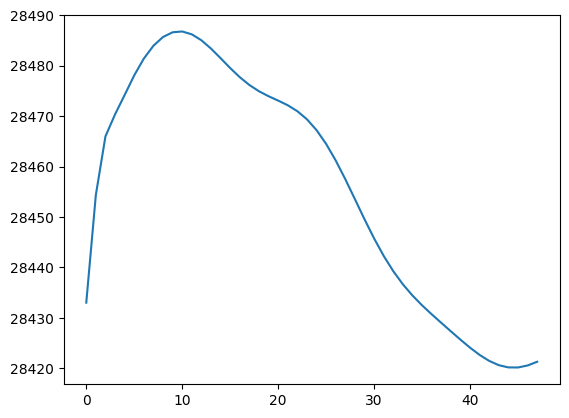

In [380]:
plt.plot(pred)

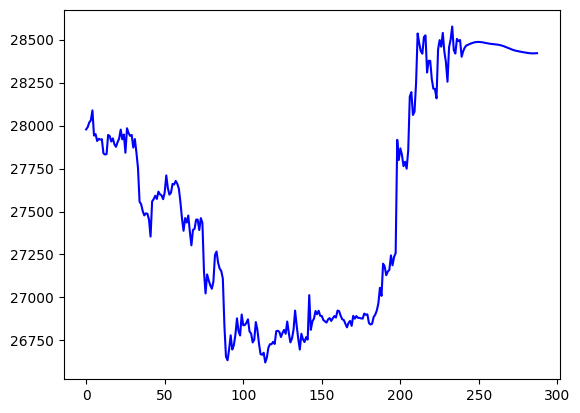

In [381]:
plt.plot(a, label='given',color='blue')
# plt.plot(np.arange(0,240),a[:240], color='blue')
# plt.plot(np.arange(240,288),a[240:], color='red')

# plt.plot(a[240:], label='predictions',color='red')